In [15]:

import json
import os
import traceback
import pandas as pd
from tqdm import tqdm
from hyperparameters import *
import pickle
import numpy as np
from llm import LLM

In [16]:
llm_0 = LLM(temperature=0, model_name="gemini-1.5-pro-latest")

def generate_goal_hypotheses(prompt):
        hypotheses = llm_0.send_message(prompt, generate_code=False, key_index=len(prompt)).split("\n")
        return [h for h in hypotheses if bool(h) == True]

In [3]:
with open("subset.txt", "r") as f:
    eval_files = f.read().splitlines()

program_descriptions = pd.read_csv("./hypo_extraction/program_db_desc.csv")

task_hypotheses = {}

for concept in tqdm(os.listdir("concept_arc/corpus/")):
    files = os.listdir(f"concept_arc/corpus/{concept}/")
    for task_name in files:

        with open(f"concept_arc/corpus/{concept}/{task_name}", "r") as f:
            task = json.load(f)

        train_inputs = []
        train_outputs = []
        test_inputs = []
        test_outputs = []

        for ex in task["train"]:
            train_inputs.append(tuple(map(tuple, ex["input"])))
            train_outputs.append(tuple(map(tuple, ex["output"])))

        for ex in task["test"]:
            test_inputs.append(tuple(map(tuple, ex["input"])))
            test_outputs.append(tuple(map(tuple, ex["output"])))

        library = []
        for f_name in dir(solver):
            if f_name[:5] == 'solve' and f_name[6:] not in eval_files:
                description = program_descriptions.loc[(program_descriptions['task_name'] == f_name[6:]+".json")].iloc[0]
                library.append([getattr(solver, f_name), description["output"]])

        program_db = program_database.ProgramDatabase(library)

        similar_programs_hypotheses, hamming_scores, neural_scores = program_db.retrieve_top_k_programs_using_nn(10, train_inputs, train_outputs) # in increasing order of similarity
        similar_programs = [p for (p, h) in similar_programs_hypotheses]
        program_hypotheses = [h for (p, h) in similar_programs_hypotheses]
        prompt = helper.goal_hypotheses_generation_prompt(NUM_ISLANDS, train_inputs, train_outputs, similar_programs, program_hypotheses)
        print(prompt)
        exit()
        hypotheses = generate_goal_hypotheses(prompt)
        task_hypotheses[task_name] = hypotheses
        with open("./concept-arc-hypotheses", "wb") as f:
            pickle.dump(task_hypotheses, f)

In [4]:
# task_hypotheses

In [5]:
with open("concept-arc-hypotheses", "rb") as f:
    task_hypotheses = pickle.load(f) 

In [6]:
dataset = {
    "sentence": [],
    "label": []
}
concepts = os.listdir("concept_arc/corpus/")
concepts_to_labels = dict(zip(concepts, range(len(concepts))))

for concept in concepts:
    files = os.listdir(f"concept_arc/corpus/{concept}/")
    for task_name in files:
        num_examples = len(task_hypotheses[task_name])
        dataset["sentence"] += task_hypotheses[task_name]
        dataset["label"] += [concepts_to_labels[concept]] * num_examples

In [7]:
from datasets import Dataset

dataset = Dataset.from_dict(dataset)

/Users/kartik/anaconda3/envs/arc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dataset = dataset.train_test_split(test_size=0.1, shuffle=True)

In [9]:
from sentence_transformers import SentenceTransformer, SentenceTransformerTrainer, losses, SentenceTransformerTrainingArguments

model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="euclidean")
loss = losses.BatchAllTripletLoss(model)

args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="fintuned_sentence_transformer",
    # Optional training parameters:
    num_train_epochs=20,
    eval_strategy="steps",
    eval_steps=200,
)
trainer = SentenceTransformerTrainer(
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    loss=loss,
    args=args
)
trainer.train()

/Users/kartik/anaconda3/envs/arc/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
                                                  
 10%|█         | 201/1980 [00:37<11:31,  2.57it/s]

{'eval_loss': 3.8240232467651367, 'eval_runtime': 0.7545, 'eval_samples_per_second': 116.628, 'eval_steps_per_second': 14.579, 'epoch': 2.02}


                                                  
 20%|██        | 401/1980 [01:11<07:58,  3.30it/s]

{'eval_loss': 3.4340803623199463, 'eval_runtime': 0.5173, 'eval_samples_per_second': 170.114, 'eval_steps_per_second': 21.264, 'epoch': 4.04}


 25%|██▌       | 500/1980 [01:27<04:13,  5.84it/s]

{'loss': 4.0718, 'grad_norm': 8.444976806640625, 'learning_rate': 3.7373737373737376e-05, 'epoch': 5.05}


                                                  
 30%|███       | 601/1980 [01:46<08:02,  2.86it/s]

{'eval_loss': 3.656254768371582, 'eval_runtime': 0.5708, 'eval_samples_per_second': 154.168, 'eval_steps_per_second': 19.271, 'epoch': 6.06}


                                                  
 40%|████      | 801/1980 [02:18<05:34,  3.53it/s]

{'eval_loss': 4.0970635414123535, 'eval_runtime': 0.4641, 'eval_samples_per_second': 189.601, 'eval_steps_per_second': 23.7, 'epoch': 8.08}


 51%|█████     | 1000/1980 [02:48<02:34,  6.32it/s]

{'loss': 3.9772, 'grad_norm': 0.11796115338802338, 'learning_rate': 2.474747474747475e-05, 'epoch': 10.1}


                                                   
 51%|█████     | 1000/1980 [02:49<02:34,  6.32it/s]

{'eval_loss': 3.777533531188965, 'eval_runtime': 0.4434, 'eval_samples_per_second': 198.483, 'eval_steps_per_second': 24.81, 'epoch': 10.1}


                                                   
 61%|██████    | 1201/1980 [03:21<03:54,  3.33it/s]

{'eval_loss': 3.628709316253662, 'eval_runtime': 0.5117, 'eval_samples_per_second': 171.97, 'eval_steps_per_second': 21.496, 'epoch': 12.12}


                                                   
 71%|███████   | 1401/1980 [03:51<02:47,  3.46it/s]

{'eval_loss': 3.602863073348999, 'eval_runtime': 0.4804, 'eval_samples_per_second': 183.194, 'eval_steps_per_second': 22.899, 'epoch': 14.14}


 76%|███████▌  | 1500/1980 [04:06<01:13,  6.54it/s]

{'loss': 3.9804, 'grad_norm': 0.36126986145973206, 'learning_rate': 1.2121212121212122e-05, 'epoch': 15.15}


                                                   
 81%|████████  | 1601/1980 [04:23<01:51,  3.41it/s]

{'eval_loss': 3.6134233474731445, 'eval_runtime': 0.5058, 'eval_samples_per_second': 173.976, 'eval_steps_per_second': 21.747, 'epoch': 16.16}


                                                   
 91%|█████████ | 1801/1980 [04:53<00:52,  3.40it/s]

{'eval_loss': 3.6149985790252686, 'eval_runtime': 0.488, 'eval_samples_per_second': 180.337, 'eval_steps_per_second': 22.542, 'epoch': 18.18}


100%|██████████| 1980/1980 [05:20<00:00,  6.18it/s]

{'train_runtime': 320.4329, 'train_samples_per_second': 49.433, 'train_steps_per_second': 6.179, 'train_loss': 3.985900632299558, 'epoch': 20.0}


TrainOutput(global_step=1980, training_loss=3.985900632299558, metrics={'train_runtime': 320.4329, 'train_samples_per_second': 49.433, 'train_steps_per_second': 6.179, 'total_flos': 0.0, 'train_loss': 3.985900632299558, 'epoch': 20.0})

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

N_CLASSES = 16

def plot_tsne(embedding, labels):
    tsne = TSNE(n_components=2, learning_rate='auto', perplexity=3, random_state=42)
    X_embedded = tsne.fit_transform(embedding)

    colors = plt.cm.get_cmap('tab20', N_CLASSES).colors

    for class_label in range(N_CLASSES):
        plt.scatter(X_embedded[:,0][labels == class_label], X_embedded[:,1][labels == class_label])

    plt.show()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/var/folders/1c/kbl_72tx4d960kspn1b5wr380000gn/T/ipykernel_42320/1353719054.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', N_CLASSES).colors


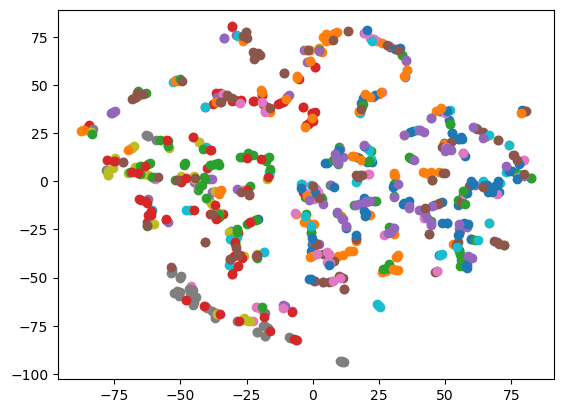

In [11]:
train_embedding = model.encode(dataset["train"]["sentence"])
train_labels = np.array(dataset["train"]["label"])
plot_tsne(train_embedding, train_labels)

/var/folders/1c/kbl_72tx4d960kspn1b5wr380000gn/T/ipykernel_42320/1353719054.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', N_CLASSES).colors


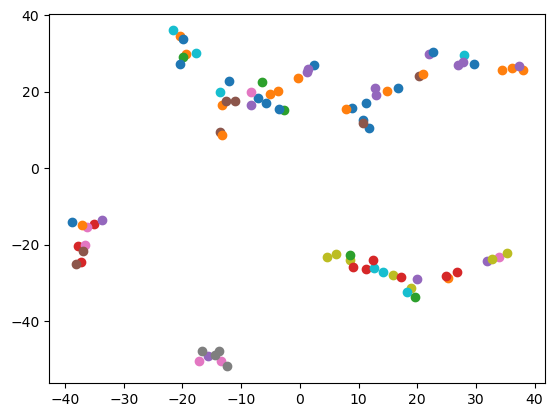

In [12]:
train_embedding = model.encode(dataset["test"]["sentence"])
train_labels = np.array(dataset["test"]["label"])
plot_tsne(train_embedding, train_labels)

In [14]:
model.similarity(np.array([1.0,2.0,3.0]), np.array([1.0,2.0,3.0]))

tensor([[-0.]], dtype=torch.float64)